In [1]:
import torch
import pandas as pd

import Utils.PTModel.Training as Training
import Utils.Data.DataLoading as DataLoading
import Utils.EvaluationMetrics.TSNEVisual as TSNEVisual
import Utils.PTModel.Inference as Inference

In [2]:
# Loading standard train test split
TrainingData = DataLoading.LoadTrainTestData("../data/tomData/unshuffled3x3tiles.csv", shuffle=True)

TFIDF Weight Array: tensor([2.1321, 2.5497, 4.8471, 1.5824, 6.8857, 5.3510, 4.9313, 2.6795, 5.1142,
        6.2026, 6.4670, 4.0443, 1.8435])


In [3]:
model = Training.TrainModel(TrainingData, 50, 32)

/home/surfytom/Projects/Dissertation/Repos/TileEmbeddingDissertation/srcTom/Utils/PTModel/Training.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  xTextbatch = torch.tensor(trainData.iloc[j:j+batchSize]["encodedAffordances"].tolist(), dtype=torch.float32).to(device)


Epoch 0: loss 6324.487190205928
Epoch 1: loss 3521.8924042344306
Epoch 2: loss 2325.8986300371894
Epoch 3: loss 1554.4913352844346
Epoch 4: loss 1043.2599395155694
Epoch 5: loss 696.4791448942086
Epoch 6: loss 454.7091060116702
Epoch 7: loss 283.827789658975
Epoch 8: loss 169.0606051592378
Epoch 9: loss 97.96357645065281
Epoch 10: loss 57.85433938278822
Epoch 11: loss 36.12441721944995
Epoch 12: loss 24.284105177247504
Epoch 13: loss 17.396587083648832
Epoch 14: loss 13.078695038919127
Epoch 15: loss 9.769624821881418
Epoch 16: loss 7.88805555662084
Epoch 17: loss 6.0547529928002435
Epoch 18: loss 5.131777827312002
Epoch 19: loss 4.419543199916081
Epoch 20: loss 3.120154202831363
Epoch 21: loss 2.8332902106256297
Epoch 22: loss 2.45934026120611
Epoch 23: loss 2.5238776473761875
Epoch 24: loss 2.0581597332209083
Epoch 25: loss 1.8626824665027233
Epoch 26: loss 1.6632500348569657
Epoch 27: loss 1.6213866477537748
Epoch 28: loss 2.0268549529527897
Epoch 29: loss 2.493267430875907
Epoch 30

In [4]:
torch.save(model, "Models/firstTry.pt")

In [6]:
Inference.SaveUnifiedRepresentation(model, pd.concat([TrainingData["trainData"], TrainingData["testData"]]), "../data/tomData/unifiedRep/firstTryModel")

Does not exists


In [7]:
data, fitEmbeddings = TSNEVisual.TrainTSNEModel("../data/tomData/unifiedRep/firstTryModel")

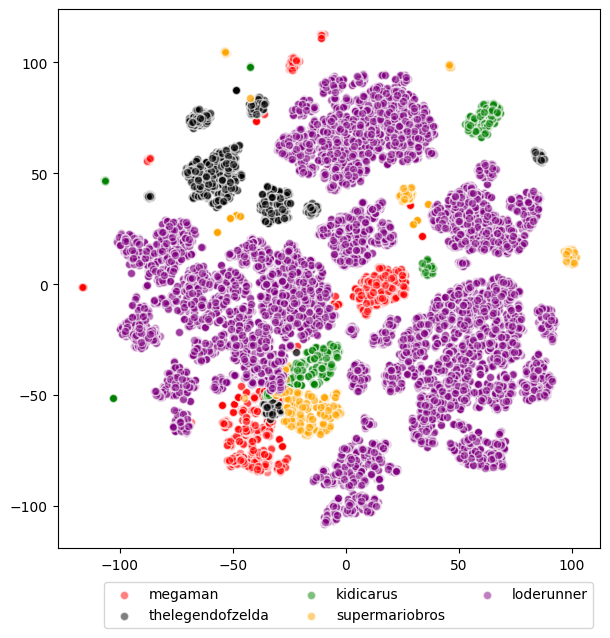

In [8]:
TSNEVisual.DisplayTSNEEmbeddings(data, fitEmbeddings)